#Source
https://stackabuse.com/autoencoders-for-image-reconstruction-in-python-and-keras

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


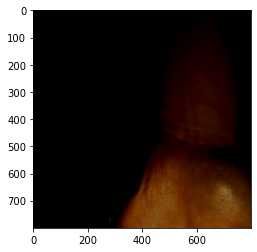

In [2]:
import os.path
#import matplotlib.image as mpimg
import cv2

import matplotlib.pyplot as plt
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))
    
def load_images(folder, x = 50, y = 50, w = 800, h = 800):
    images = []
    for filename in os.listdir(folder):
        if '.jpg' in filename: 
            img = cv2.imread(os.path.join(folder, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #img = mpimg.imread(os.path.join(folder, filename))
            #print(img.min(), img.max())
            crop_img = img[y:y+h, x:x+w]
            #plt.imshow(crop_img)
            crop_img = crop_img.astype('float32') / 255.0 - 0.5
            if crop_img is not None:
                images.append(crop_img)
    return images


fpath = "D:/elena/Google Drive/titech/research/experiments/output/hsi/handsOnly/rgb"
allImage = load_images(fpath) 
allImage = np.array(allImage) #, dtype=object
plt.imshow(allImage[0])


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(allImage, test_size=0.1, random_state=42)
print(X_train.shape, X_test.shape)

(8, 800, 800, 3) (1, 800, 800, 3)


In [4]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [6]:
IMG_SHAPE = allImage.shape[1:]
print(IMG_SHAPE)
encoder, decoder = build_autoencoder(IMG_SHAPE, 1000)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
#autoencoder.compile(optimizer='adamax', loss='mse')
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

print(autoencoder.summary())

(800, 800, 3)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 800, 800, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 1000)              1920001000
_________________________________________________________________
sequential_3 (Sequential)    (None, 800, 800, 3)       1921920000
Total params: -453,046,296
Trainable params: -453,046,296
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=20,
                validation_data=(X_test, X_test))

Epoch 1/20
1/1 [==============================] - 22s 22s/step - loss: 0.0605 - val_loss: 0.0913
Epoch 2/20
1/1 [==============================] - 19s 19s/step - loss: 0.2599 - val_loss: 240.4720
Epoch 3/20
1/1 [==============================] - 9s 9s/step - loss: 1042.7493 - val_loss: 32.8599
Epoch 4/20
1/1 [==============================] - 9s 9s/step - loss: 560.7438 - val_loss: 393.7141
Epoch 5/20
1/1 [==============================] - 9s 9s/step - loss: 276.5474 - val_loss: 967.7355
Epoch 6/20
1/1 [==============================] - 9s 9s/step - loss: 1446.6875 - val_loss: 733.9778
Epoch 7/20
1/1 [==============================] - 9s 9s/step - loss: 7201.9326 - val_loss: 59.5971
Epoch 8/20
1/1 [==============================] - 9s 9s/step - loss: 772.9559 - val_loss: 211.7848
Epoch 9/20
1/1 [==============================] - 9s 9s/step - loss: 2722.3904 - val_loss: 138.9194
Epoch 10/20
1/1 [==============================] - 9s 9s/step - loss: 492.4214 - val_loss: 164.7813
Epoch 11/

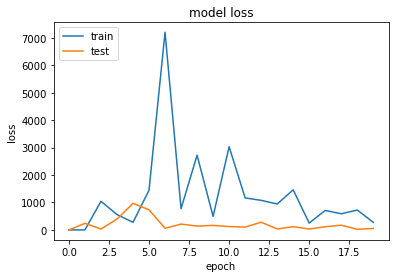

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


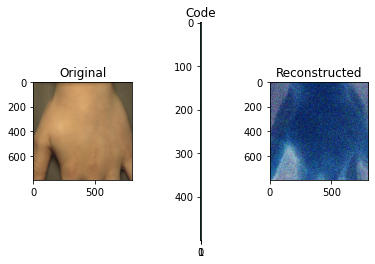

In [11]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

for i in range(len(X_test)):
    img = X_test[i]
    visualize(img,encoder,decoder)